IMPORT LIBRARIES

In [40]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


IMPORT THE DATASET

In [41]:
data = pd.read_csv('labeled_data.csv')

MAP THE COLUMNS FOR HATE SPEECH

In [42]:
data['labels'] = data['class'].map({0: "Hate speech", 1: "Offensive language", 2: "Normal"})
data = data[["tweet", "labels"]]

CLEAN THE SENTENCE IN DATASET

In [43]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopwords_set]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    return " ".join(text)

data["tweet"] = data["tweet"].apply(clean)


  TRAIN DATASET

In [44]:
x = np.array(data["tweet"])
y = np.array(data["labels"])

cv = CountVectorizer()
X = cv.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state= 42)
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(max_depth=20, class_weight='balanced', random_state=42)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', random_state=42)

# from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [45]:
y_pred = model.predict(X_test)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# IoU Calculation (approximation)
conf_mat = confusion_matrix(y_test, y_pred)
intersection = np.diag(conf_mat)
ground_truth = conf_mat.sum(axis=1)
predicted = conf_mat.sum(axis=0)
union = ground_truth + predicted - intersection
iou = np.mean(intersection / union)

# Display the metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")


Accuracy:  0.9012
Precision: 0.7506
Recall:    0.8596
F1 Score:  0.7904
IoU:       0.6875


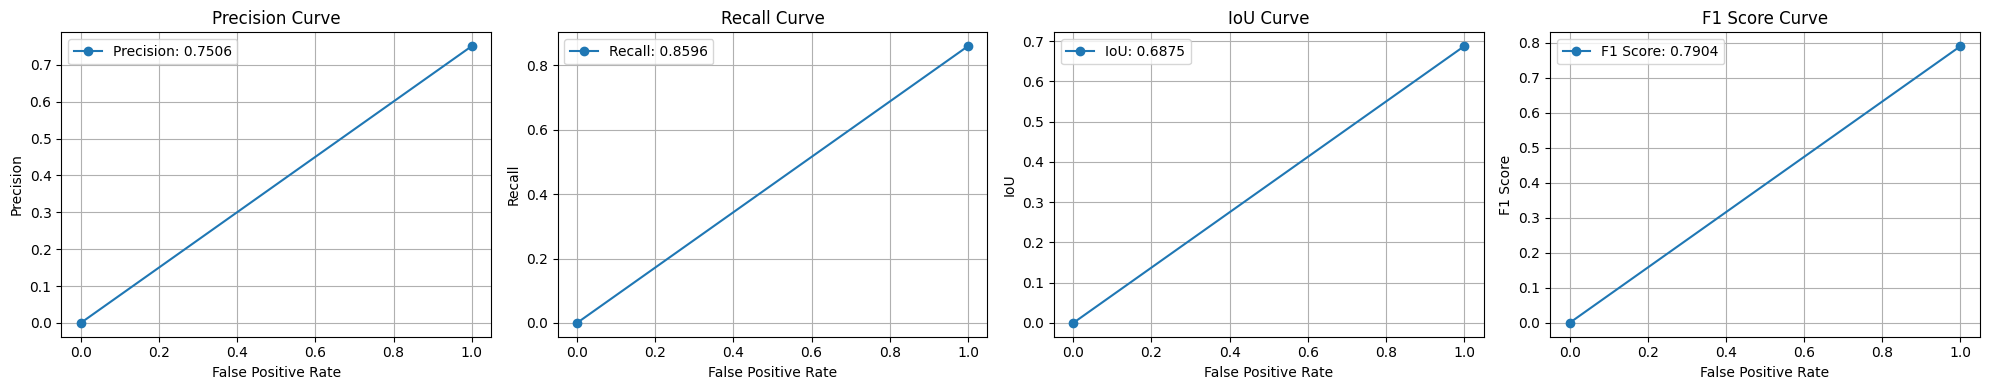

In [47]:
#Plot metric curves (dummy FPR axis to mimic visual)
fpr_dummy = [0, 1]

def plot_metric_curve(metric_value, name):
    plt.plot(fpr_dummy, [0, metric_value], label=f"{name}: {metric_value:.4f}", marker='o')
    plt.xlabel("False Positive Rate")
    plt.ylabel(name)
    plt.title(f"{name} Curve")
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plot_metric_curve(precision, "Precision")

plt.subplot(1, 4, 2)
plot_metric_curve(recall, "Recall")

plt.subplot(1, 4, 3)
plot_metric_curve(iou, "IoU")

plt.subplot(1, 4, 4)
plot_metric_curve(f1, "F1 Score")

plt.tight_layout()
plt.show()


VALIDATE THE DATASET

In [50]:
sample = "love"
sample_data = cv.transform([sample]).toarray()
print(model.predict(sample_data))

['Normal']


SAVE THE MODEL AND VECTORIZER

In [51]:
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(cv, open('vectorizer.pkl', 'wb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')